# One-time

In [1]:
!pip install transformers datasets evaluate -q
!pip install jiwer -q

In [2]:
import kagglehub

# Download latest version
dataset_path = kagglehub.dataset_download("hammadjavaid/6992-labeled-meme-images-dataset")

print("Path to dataset files:", dataset_path)

Path to dataset files: /kaggle/input/6992-labeled-meme-images-dataset


# Imports

In [3]:
import numpy as np
import pandas as pd
# import re
from PIL import Image
from os import listdir
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, IterableDataset
from torchvision.transforms import Normalize, ToTensor, Compose, Resize
from transformers import AutoModelForCausalLM
from transformers import AutoProcessor

# Dataset

In [4]:
trans = Compose([
    Resize((224, 224)),
    #ToTensor(),
    #Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class CustomDataset(Dataset):
    def __init__(self, path, data=None):
        self.path = path
        self.path_images = path + '/images/images/'
        if data is not None:
            self.data = data
        else:
            self.data = self._import_dataset(path)

    def _import_dataset(self, path):
        labels = pd.read_csv(path + '/labels.csv')
        labels.dropna(axis=0, inplace=True)
        # @TODO: clean labels from "something.com"
        return {
            'image': labels['image_name'].to_numpy(),
            'text': labels['text_corrected'].to_numpy(),
        }

    def set_transform(self, transform):
        self.transform = transform  # Set the transform function

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = trans(Image.open(self.path_images + self.data['image'][index]))
        label = self.data['text'][index]

        #if self.transform:
        #    res = self.transform(res)  # Apply the transform if it's set

        return sample, label
    
    def get_picture(self, index):
        return Image.open(self.path_images + self.data['image'][index])

    def train_test_split(self, test_size=0.1, shuffle=True):
        if shuffle:
            indices = np.random.permutation(len(self.data['image']))
        split_point = int(len(self.data['image']) * test_size)

        # Split indices into train and test
        test_idxs = indices[:split_point]
        train_idxs = indices[split_point:]

        return {
            'train': CustomDataset(self.path, {
                'image': self.data['image'][train_idxs],
                'text': self.data['text'][train_idxs],
            }),
            'test': CustomDataset(self.path, {
                'image': self.data['image'][test_idxs],
                'text': self.data['text'][test_idxs],
            })
        }

In [5]:
checkpoint = "microsoft/git-base"
processor = AutoProcessor.from_pretrained(checkpoint)
#processor.do_resize = False

preprocessor_config.json:   0%|          | 0.00/503 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/453 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [6]:
dataset = CustomDataset(dataset_path)

In [7]:
split = dataset.train_test_split(test_size=0.1)
train_ds = split["train"]
val_ds = split["test"]

In [8]:
print(train_ds[0])
print(val_ds[0])

(<PIL.Image.Image image mode=RGB size=224x224 at 0x78A8A49D2800>, "The problem isn't so much that Hillary is a corrupt lying criminal. Everyone knows this. The PROBLEM is that her supporters don't care.")
(<PIL.Image.Image image mode=RGB size=224x224 at 0x78A8A49D27A0>, 'WA Go THE ONLY THING YOU NEED IS AN UNSHAKEABLE BELIEF IN YOURSELF! What Wouluarvey Do?')


## Dataset preprocessing

In [9]:
'''def preprocess(example_batch):
    images = [trans(x) for x in example_batch["image"]]
    captions = [x for x in example_batch["text"]]
    inputs = processor(images=images, text=captions, padding="max_length")
    inputs.update({"labels": inputs["input_ids"]})
    return inputs

def preprocess(batch):
    #images = [x for x in dataset["image"]]
    #captions = [x for x in dataset["label"]]
    inputs = processor(images=[batch[0]], text=[batch[1]], padding="max_length")
    inputs.update({"labels": inputs["input_ids"]})
    return inputs


train_ds.set_transform(preprocess)
val_ds.set_transform(preprocess)'''

'def preprocess(example_batch):\n    images = [trans(x) for x in example_batch["image"]]\n    captions = [x for x in example_batch["text"]]\n    inputs = processor(images=images, text=captions, padding="max_length")\n    inputs.update({"labels": inputs["input_ids"]})\n    return inputs\n\ndef preprocess(batch):\n    #images = [x for x in dataset["image"]]\n    #captions = [x for x in dataset["label"]]\n    inputs = processor(images=[batch[0]], text=[batch[1]], padding="max_length")\n    inputs.update({"labels": inputs["input_ids"]})\n    return inputs\n\n\ntrain_ds.set_transform(preprocess)\nval_ds.set_transform(preprocess)'

# Pretrain download

# Login

In [10]:
from huggingface_hub import notebook_login
notebook_login()

In [11]:
import wandb
wandb.login(key='12a108ce38a9133f9cd15eae05a1eab4df7d0d72')

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Training

In [15]:
from evaluate import load
wer = load("wer")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predicted = logits.argmax(-1)
    decoded_labels = processor.batch_decode(labels, skip_special_tokens=True)
    decoded_predictions = processor.batch_decode(predicted, skip_special_tokens=True)
    wer_score = wer.compute(predictions=decoded_predictions, references=decoded_labels)
    return {"wer_score": wer_score}

In [16]:
def collate_fn(batch):
    #print(batch)
    images = [example[0] for example in batch]
    texts = [example[1] for example in batch]
    inputs = processor(images=images, text=texts, padding="max_length", return_tensors="pt")
    inputs.update({"labels": inputs["input_ids"]})
    '''inputs.update({"labels": inputs["input_ids"]})
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v)'''

    return {k:v.squeeze() for k,v in inputs.items()}

In [55]:
from transformers import TrainingArguments, Trainer

model_name = checkpoint.split("/")[1]

training_args = TrainingArguments(
    output_dir=f"shitpost",
    learning_rate=1e-5,
    num_train_epochs=1000,
    fp16=True,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=2,
    save_total_limit=3,
    eval_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    save_steps=50,
    logging_steps=50,
    remove_unused_columns=False,
    push_to_hub=True,
    label_names=["labels"],
    load_best_model_at_end=True,
)

model = AutoModelForCausalLM.from_pretrained(checkpoint)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

try:
    trainer.train()
except KeyboardInterrupt:
    pass

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss,Wer Score
50,4.460400,8.123326,28.311111
100,3.662900,7.111104,27.733333
150,3.165500,6.155255,17.911111
200,2.688600,5.245842,6.111111
250,2.235200,4.385053,4.288889
300,1.811800,3.580525,3.600000
350,1.423900,2.858216,2.911111
400,1.079000,2.240235,2.444444
450,0.785400,1.725959,2.222222
500,0.550100,1.331590,2.022222


In [53]:
'''try:
    trainer.train()
except KeyboardInterrupt:
    pass'''

Step,Training Loss,Validation Loss,Wer Score
50,0.014900,0.633030,2.600000
100,0.000900,0.642820,2.622222


In [67]:
import requests
from io import BytesIO
url = "https://configcat.com/blog/assets/images/1-no-option-25b3e991dae257904057799db9410a1b.jpg"
response = requests.get(url)
img_random = Image.open(BytesIO(response.content))

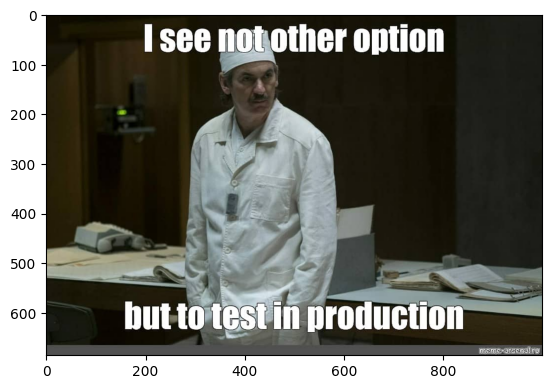

tensor([[ 101, 1045, 2156, 2060, 2028, 1005, 2222, 2022, 2445, 1012,  102]],
       device='cuda:0')
"i see other one ' ll be given."


In [68]:
import matplotlib.pyplot as plt
plt.imshow(img_random)
plt.show()
device = "cuda" if torch.cuda.is_available() else "cpu"

inputs = processor(images=trans(img_random), return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_ids)
print(f'"{generated_caption}"')